## **Previsão de acidentes em Recife**

### Objetivo:
Baseado nos registros de ocorrência de acidentes em Recife (2015-2019), criar um modelo de previsão de séries temporais. Para isso, os dados de 2015 à 2018 serão utilizados como treinamento do modelo. Já os dados de 2019 serão utilizados para validação do modelo aplicando-se a validação walk-foward.  

### Etapas nesse notebook:
1. Entendimento dos dados e criação do dataset
2. Pré-processamento dos dados
3. Identificação de outliers
4. Análise dos dados

### 1. Entendimento dos dados e Criação do Dataset
#### Planilhas
**acidentes-transito-2015.csv**: 7273 x 24

**acidentes_2016.csv**: 11263 x 47

**acidentes_2017.csv**: 11758 x 32

**acidentes_2018.csv**: 11411 x 45

**acidentes-2019.csv**: 12062 x 47

Todas foram concatenadas em um único DataFrame de dimensões 53767 x 24


In [1]:
# List every file in our dataset
import os
import pandas as pd

def get_filesname(PATH):
  filesnames = os.listdir(PATH)
  filesnames_csv = [f for f in filesnames if (f.lower().endswith(".csv"))]
  return filesnames_csv

def get_files_info(filesnames, PATH):
  total_data = 0
  for f in filesnames:
    data = pd.read_csv(PATH + '/' + f)
    print(str(f) + ' has shape of' + str(data.shape))
    total_data += data.shape[0]
  return total_data

PATH = 'dataset'
filesnames = get_filesname(PATH)
total_data = get_files_info(filesnames, PATH)

acidentes-2019.csv has shape of(12062, 47)
acidentes-transito-2015.csv has shape of(7273, 24)
acidentes_2016.csv has shape of(11263, 47)
acidentes_2017.csv has shape of(11758, 32)
acidentes_2018.csv has shape of(11411, 45)


In [2]:
# Create unique dataset
def create_data_set(files):
  main_df = pd.DataFrame(pd.read_csv(PATH + '/' + files[0]))
  # Filter unname columns
  main_df.drop(main_df.filter(regex="Unname"),axis=1, inplace=True)
  for i in range(1,len(files)):
    data = pd.read_csv(PATH + '/' + files[i])
    df = pd.DataFrame(data)
    df.drop(df.filter(regex="Unname"),axis=1, inplace=True)
    main_df = pd.concat([main_df,df],axis=0, ignore_index=True)

  return main_df

In [3]:
df = create_data_set(filesnames)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53767 entries, 0 to 53766
Data columns (total 42 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   data                       53767 non-null  object 
 1   hora                       53712 non-null  object 
 2   natureza_acidente          53347 non-null  object 
 3   situacao                   53715 non-null  object 
 4   bairro                     53475 non-null  object 
 5   endereco                   53544 non-null  object 
 6   numero                     23998 non-null  object 
 7   detalhe_endereco_acidente  6656 non-null   object 
 8   complemento                50597 non-null  object 
 9   endereco_cruzamento        46360 non-null  object 
 10  numero_cruzamento          34215 non-null  object 
 11  referencia_cruzamento      42189 non-null  object 
 12  bairro_cruzamento          46108 non-null  object 
 13  num_semaforo               5745 non-null   obj

In [4]:
# Check dataset
if total_data == df.shape[0]:
  print('Correct Dataset')
else:
  print('Wrong Dataset')

Correct Dataset


A ingestão dos dados foi bem sucedida, pois não se perdeu nenhum registro na integração dos datasets.

### 2. Pré-processamento dos dados

Por serem dados históricos, é esperado que os dados estejam com "status" de **FINALIZADO**. Registros com situação diferente podem ser tratados como erros na ingestão dos dados.

Além desse campo, foram analisados os tipos de acidentes possíveis, sendo encontradas 3252 ocorrências distintas. Observando mais atentamente os dados, percebe-se que há algum tipo de falha em seu posicionamento na tabela, atribuindo endereços aos tipos de acidentes.

Contudo, para o que está com status de FINALIZADO, foi decidido manter tais informações, pois houve um consentimento da pessoa/sistema que aprovou o registro *(esse é um caso a ser discutido com o time de negócio)*.

In [5]:
df.columns

Index(['data', 'hora', 'natureza_acidente', 'situacao', 'bairro', 'endereco',
       'numero', 'detalhe_endereco_acidente', 'complemento',
       'endereco_cruzamento', 'numero_cruzamento', 'referencia_cruzamento',
       'bairro_cruzamento', 'num_semaforo', 'sentido_via', 'tipo', 'descricao',
       'auto', 'moto', 'ciclom', 'ciclista', 'pedestre', 'onibus', 'caminhao',
       'viatura', 'outros', 'vitimas', 'vitimasfatais', 'acidente_verificado',
       'tempo_clima', 'situacao_semaforo', 'sinalizacao', 'condicao_via',
       'conservacao_via', 'ponto_controle', 'situacao_placa',
       'velocidade_max_via', 'mao_direcao', 'divisao_via1', 'divisao_via2',
       'divisao_via3', 'natureza'],
      dtype='object')

In [6]:
df['situacao'].value_counts()

FINALIZADA                42521
CANCELADA                  9888
EM ATENDIMENTO              575
PENDENTE                    422
DUPLICIDADE                 150
EQUIPE EM DESLOCAMENTO      113
EM ABERTO                    33
EQUIPE NO LOCAL              13
Name: situacao, dtype: int64

ConversionError: Failed to convert value(s) to axis units: 0        FINALIZADA
1        FINALIZADA
2         CANCELADA
3         CANCELADA
4        FINALIZADA
            ...    
53762    FINALIZADA
53763    FINALIZADA
53764    FINALIZADA
53765    FINALIZADA
53766     CANCELADA
Name: x, Length: 53767, dtype: object

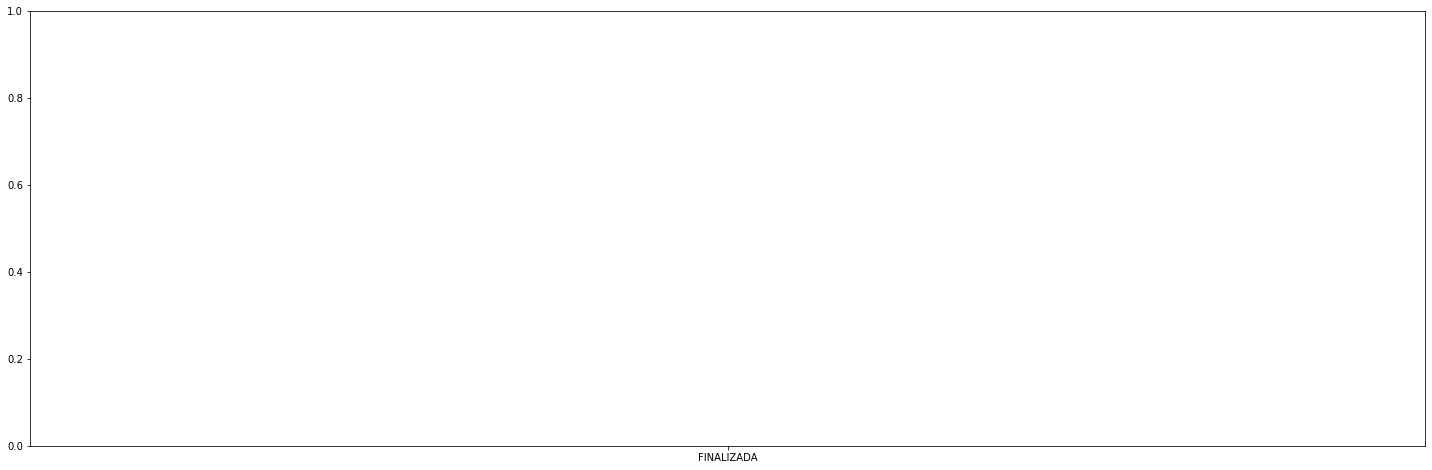

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
fig_dims = (25, 8)
fig, ax = plt.subplots(1,1, figsize=fig_dims, sharey=True)

sns.histplot(x="situacao", ax=ax, data=df)

In [ ]:
df['tipo'].value_counts()

In [ ]:
filter_tipo = df.groupby('tipo')['tipo'].filter(lambda x: len(x) >= 10)
fig_dims = (35, 10)
fig, ax = plt.subplots(1,1, figsize=fig_dims, sharey=True)

sns.histplot(x=filter_tipo, ax=ax)

In [ ]:
# Dataset has some shifted feature values
shifted_df = df[(df['tipo'] != 'COLISÃO') & (df['situacao'] == 'FINALIZADA')]
shifted_df.head(10)

In [ ]:
def filter_data(df):
  filter_df = df[df['situacao'] == 'FINALIZADA']
  #TODO: include more filters?
  return filter_df

In [ ]:
filter_df = filter_data(df)
filter_df.head()

Este é um dos tópicos que precisam ser discutidos com o time de negócios. Fiz uma inferência de que os dados com situação diferente de "FINALIZADO" não são importantes para a série temporal. Isso pode ser revisado de acordo com as regras de negócio.

### 3. Identificação de outliers

Foram implementadas duas abordagens para identificação de outliers:

**DBSCan:** método não supervisionado que busca gerar clusters a partir da população proposta. Como o dataset possui muitos dados categóricos, foram selecionadas duas características para serem analisadas (tipo e natureza_acidente).  De acordo com os parâmetros de entrada, um cluster é formado por no mínimo 40 pontos (min_sample). Aqueles que ficarem distantes dos clusters formados (eps) são considerados *outliers*. 

**Heurística:** método customizado que considera a frequência dos tipos de acidentes. A heurística seleciona apenas tipos com mais do que 10 ocorrências e que não contenham a "palavra" **SENT**. Os registros que não se enquadram nessas regras são tidos como *outliers*. *(Esse tipo de heurística precisa ser analisada e validada pelo time de negócios)*

In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

def get_data_outliers(df):
  # Change to category columns
  df["tipo"] = df["tipo"].astype('category')
  df["natureza_acidente"] = df["natureza_acidente"].astype('category')
  df['tipo_num'] = df["tipo"].cat.codes
  df['natureza_acidente_num'] = df["natureza_acidente"].cat.codes

  outliers_df = df[['tipo_num', 'natureza_acidente_num']]
  outliers_df = StandardScaler().fit_transform(outliers_df)
  db = DBSCAN(eps=0.3, min_samples = 40).fit(outliers_df)
  labels = db.labels_
  print(len(labels))
  df['outliers'] = labels
  results = df[df['outliers'] != -1]
  
  return results
  

In [ ]:
def get_data_custom_outliers(df):
  df_type = df.groupby('tipo').size().reset_index()
  df_type = df_type.rename(columns={0: "Freq"})
  df_type_filter = df_type[(df_type['Freq'] > 10)]

  df_outliers = df_type_filter[~df_type_filter["tipo"].str.contains('SENT')]
  correct_types = list(df_outliers['tipo'])

  bool_type = df.tipo.isin(correct_types)
  print(len(bool_type))
  results = df[bool_type]
  return results

In [ ]:
def pre_processing(type, df):
  filter_df = filter_data(df)
  if type=='custom':
    results = get_data_custom_outliers(filter_df)
  elif type == 'dbscan':
    results = get_data_outliers(filter_df)
  else:
    result = filter_df
  return results

In [ ]:
filter_df = pre_processing("dbscan", df)

Aqui é mais um tópico que precisa ser alinhado com o time de negócio. Decidi manter o "DBScan" como filtro final, pois ele identificou poucos outliers

### 4. Análise dos dados

Análise dos dados agrupados ao longo do tempo (série temporal).

Etapas
1. Análise preliminares
2. Análise dos lags
3. Análise de estacionariedade
4. Análise de sazonalidade


#### 4.1 Análises preliminares
Ao fazermos o agrupamento dos dados, é necessário garantir que todos os períodos que estejam dentro do range requerido existem.

In [ ]:
# Compare date_range values
def check_date_range(df):
  df['data'] = pd.to_datetime(df['data'])
  nominal_days = ((max(df.data) - min(df.data)).days+1)
  actual_days = len(df['data'].value_counts())
  return nominal_days == actual_days

# Fix date_range if necessary
def fix_date_range(df):
  print('df length: ')
  print(len(df))
  idx = pd.date_range(min(df['data']), max(df['data']))
  df_i = df.set_index('data')
  df_i.index = pd.DatetimeIndex(df_i.index)
  df_i = df_i.reindex(idx, fill_value=0)
  print('new_df length: ')
  print(len(df_i))
  return df_i

# Group data with frequency
def group_data(df):
  df_freq = df.groupby('data').size().reset_index()
  df_freq = df_freq.rename(columns={0: "Freq"})
  if check_date_range(df_freq):
    print('Same date range length.')
    results = df_freq.set_index('data')
  else:
    print('Different date range length.')
    results = fix_date_range(df_freq)
    
  return results

In [ ]:
df_freq = group_data(filter_df)
df_freq.to_csv('grouped_accident_data.csv')
df_freq.head()

In [ ]:
sns.set_theme(style="darkgrid")
fig_dims = (35, 10)
fig, ax = plt.subplots(1,1, figsize=fig_dims, sharey=True)

sns.lineplot(x = df_freq.index, y="Freq", data=df_freq, ax=ax)

In [ ]:
sample_df = df_freq['2018-01-01':'2018-06-30']

sns.set_theme(style="darkgrid")
fig_dims = (35, 10)
fig, ax = plt.subplots(1,1, figsize=fig_dims, sharey=True)

sns.lineplot(x = sample_df.index, y="Freq", data=sample_df, ax=ax)

#### 4.2 Análise dos lags

Para análise dos *lags* relevantes da série temporal, podemos utilizar duas técnicas complementares:
1. **Naive model:** criação de um modelo considerando apenas o deslocamento dos valores na série temporal. Métrica de análise: RMSE
2. **Gráficos de autocorrelação e autocorrelação parcial:** análise da autocorrelação dos lags considerando os dados passados e os resíduos presentes na série. 

In [ ]:
from sklearn.metrics import mean_squared_error

def check_lags(df_freq, num_lags):
  results = []
  for i in range(num_lags):
    new_sample = {}
    shift_df = df_freq.shift(i+1, fill_value=0)
    new_sample['i'] = i+1
    new_sample['rmse'] = mean_squared_error(df_freq['Freq'], shift_df['Freq'], squared=False)
    results.append(new_sample)
  return pd.DataFrame(results)

In [ ]:
results = check_lags(df_freq, 50)
sns.lineplot(data=results, x="i", y="rmse")

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_freq['Freq'], lags=30)
plot_pacf(df_freq['Freq'], lags=30)
plt.show()

Pelo *naive model* é possível perceber que o **lag 7** possui grande correlação na série. Isso também é confirmado pelos gráficos de correlação. Além disso, é possível perceber que o **primeiro lag** também possui uma correlação considerável com os dados que estão sendo estudados.

#### 4.3 Análise de estacionariedade
Uma série é tido como estacionária quando o seu comportamento ao longo do tempo não possui uma tendência. Para verificar se a série é estacionária ou não, existe uma quantidade relevante de abordagens. Para esse caso, decidimos utilizar algumas:

1. **Distribuição dos valores da série:** verificar se os valores se aproximam de uma distribuição normal. Em caso afirmativo, existe uma forte premissa que a séria é estacionária
2. **Decomposição da série:** análise do comportamento da tendência para a série decomposta.
3. **Teste de hipótese Dickey-Fuller:** teste em que a hipótese nula afirma a presença de raíz unitária na série. Em caso de rejeição da hipótese nula, a série é tida como estacionária pois refuta a raíz unitária.

In [ ]:
fig_dims = (15, 8)
fig, ax = plt.subplots(1,1, figsize=fig_dims, sharey=True)
sns.histplot(data=df_freq, x="Freq", ax=ax)

In [ ]:
from statsmodels.graphics.gofplots import qqplot
fig_dims = (15, 8)
fig, ax = plt.subplots(1,1, figsize=fig_dims, sharey=True)
qqplot(df_freq['Freq'], line='s', ax=ax)
plt.show()

In [ ]:
df_freq['ano'] = pd.DatetimeIndex(df_freq.index).year

sns.boxplot(x="ano", y="Freq",
            #hue="weekend", palette=["m", "g"],
            data=df_freq)

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

full_ts_decomp = seasonal_decompose(df_freq['Freq'], freq=365)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(23,12))
full_ts_decomp.observed.plot(ax=ax1)
full_ts_decomp.trend.plot(ax=ax2)
full_ts_decomp.seasonal.plot(ax=ax3)
full_ts_decomp.resid.plot(ax=ax4)

decomposition.plot()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(df_freq['Freq'])
print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical Values:')
for key, value in dftest[4].items():
	print('\t%s: %.3f' % (key, value))

O teste de Dickey-Fuller nos aponta que a série é tida como estacionária. Além disso, a distribuição dos valores da série contribui com essa teoria. Contudo, o gráfico de tendência da série decomposta nos faz refletir um pouco mais profundamente. A princípio é possível perceber uma tendência, mas analisando o comportamento de 2015, 2016 e 2018, é possível perceber uma estabilidade. Já em 2017 e 2019 percebemos uma tendência de alta.

#### 4.4 Análise de sazonalidade
Para análise de sazonalidade, foram utilizadas 3 abordagens distintas:
1. Comportamento dos registros ao longo dos dias da semana através de um gráfico boxplot
2. Comportamento dos registros ao longo dos meses através de um gráfico boxplot
3. Comportamento da sazonalidade da série decomposta considerando uma amostragem da série em questão.

In [ ]:
df_freq['weekday'] = df_freq.index.weekday
df_freq['weekend'] = (df_freq.index.weekday // 5 == 1).astype(int)

fig, ax = plt.subplots(1,1, figsize=(15,8))
sns.boxplot(x="weekday", y="Freq",
            hue="weekend", palette=["m", "g"],
            data=df_freq, ax=ax)

In [ ]:
df_freq['mes'] = pd.DatetimeIndex(df_freq.index).month

fig, ax = plt.subplots(1,1, figsize=(15,8))
sns.boxplot(x="mes", y="Freq",
            #hue="weekend", palette=["m", "g"],
            data=df_freq, ax=ax)

In [ ]:
sample_df = df_freq['2017-01-01':'2017-12-31']
sample_ts_decomp = seasonal_decompose(sample_df['Freq'], freq=7)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(23,12))
sample_ts_decomp.observed.plot(ax=ax1)
sample_ts_decomp.trend.plot(ax=ax2)
sample_ts_decomp.seasonal.plot(ax=ax3)
sample_ts_decomp.resid.plot(ax=ax4)
plt.show()

Pelos gráficos propostos, é possível perceber que existe uma sazonalidade no **lag 7**. Isso é bem coerente, pois estamos lidando com dados diários, ou seja, existe uma correlação entre os dias da semana